In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('medical_no_show.csv', parse_dates=[3,4])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   PatientId       110527 non-null  float64            
 1   AppointmentID   110527 non-null  int64              
 2   Gender          110527 non-null  object             
 3   ScheduledDay    110527 non-null  datetime64[ns, UTC]
 4   AppointmentDay  110527 non-null  datetime64[ns, UTC]
 5   Age             110527 non-null  int64              
 6   Neighbourhood   110527 non-null  object             
 7   Scholarship     110527 non-null  int64              
 8   Hipertension    110527 non-null  int64              
 9   Diabetes        110527 non-null  int64              
 10  Alcoholism      110527 non-null  int64              
 11  Handcap         110527 non-null  int64              
 12  SMS_received    110527 non-null  int64              
 13  No-show       

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
df.rename(columns = {'Hipertension': 'Hypertension',
                         'Handcap': 'Handicap',
                        'ScheduledDay': 'AppointMade',
                        'AppointmentDay': 'AppointFor'}, inplace = True)

df.set_index('AppointmentID', inplace=True)
df['AppointMade'] = df['AppointMade'].values.astype('datetime64[s]')
df['AppointFor'] = df['AppointFor'].dt.date
df['Gender'].replace(('M', 'F'), (1, 0), inplace=True)

df.head()

dummies = pd.get_dummies(df['No-show'])
df = pd.concat((df, dummies), axis = 1)

noshow_prob = df.Yes.sum() / (df.Yes.sum() + df.No.sum())
print(noshow_prob)

0.20193255946510807


In [4]:
df.describe()

,PatientId,Gender,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No,Yes
count,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,0.350023,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,0.798067,0.201933
std,2.560949e+14,0.476979,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,0.401444,0.401444
min,3.921784e+04,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,3.173184e+13,0.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,9.439172e+13,1.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,9.999816e+14,1.000000,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000


The minimum age is -1 and the maximum is 115. The maximum being that high probably means there are a number of ages with very little sample size so we will likely put the age feature into bins at a later point. But for now lets remove and ages below 0

Age
0      3539
1      2273
2      1618
3      1513
4      1299
       ... 
98        6
99        1
100       4
102       2
115       5
Name: PatientId, Length: 103, dtype: int64


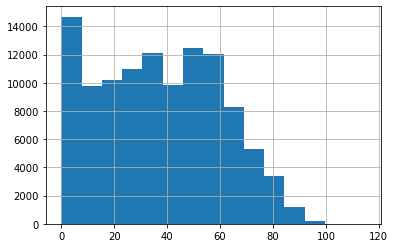

In [5]:
df = df.loc[df['Age'] >= 0]
print(df.groupby('Age')['PatientId'].count())

df['Age'].hist(bins = 15)
plt.show()

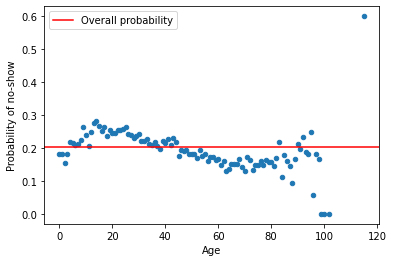

In [6]:
df_age = pd.concat([df.groupby('Age')['No'].sum(), df.groupby('Age')['Yes'].sum()], axis=1)
df_age['Probability of no-show'] = df_age['Yes'] / (df_age['No'] + df_age['Yes'])
df_age.reset_index(inplace=True)
df_age.head()
df_age.plot(kind='scatter', x='Age', y='Probability of no-show')
plt.axhline(noshow_prob, c='r', label='Overall probability')
plt.legend()
plt.show()

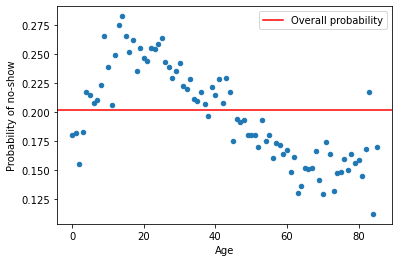

In [7]:
max_age = 85
df['Age'][df['Age'] >= max_age] = max_age


df_age = pd.concat([df.groupby('Age')['No'].sum(), df.groupby('Age')['Yes'].sum()], axis=1)
df_age['Probability of no-show'] = df_age['Yes'] / (df_age['No'] + df_age['Yes'])
df_age.reset_index(inplace=True)
df_age.head()
df_age.plot(kind='scatter', x='Age', y='Probability of no-show')
plt.axhline(noshow_prob, c='r', label='Overall probability')
plt.legend()
plt.show()

#from scipy.stats import gaussian_kde

#df_y = df[df['Yes'] == 1]
#df_n = df[df['No'] == 1]

#x_yes = df_n.Age.values
#y_yes = df_n.Yes.values

#y_yes = y_yes+0.00001*np.random.rand(len(y_yes))

#Calculate the point density
#xy = np.vstack([x_yes,y_yes])
#z = gaussian_kde(xy)(xy)

#fig, ax = plt.subplots()
#ax.scatter(x_yes, y_yes, c=z, s=100, edgecolor='')
#plt.ylim(-0.1, 1.1)
#plt.show()

It looks like there is a polynomial relationship with age and probability of showing up for a medical appointment. To me it looks like we would be better using polynomial terms rather than bins for the 'Age' feature and we just reduce all values above 85 down to 85. It is around 85 that there are too few data points per year to give accurate probabilities.

Correlation for Handicap is -  -0.006076846582439237
Correlation for handicap - 0 is 0.007281409275944209
Correlation for handicap - 1 is -0.007757374294273439
Correlation for handicap - 2 is 2.550375494778824e-05
Correlation for handicap - 3 is 0.0007790371412119528
Correlation for handicap - 4 is 0.0017053037239939887


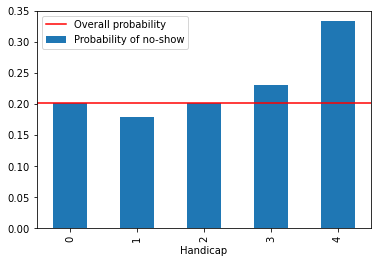

In [8]:
print('Correlation for Handicap is - ', df['Handicap'].corr(df['Yes']))

dummies = pd.get_dummies(df['Handicap'])
for dum in dummies.columns:
    cor = dummies[dum].corr(df['Yes'])
    print(f'Correlation for handicap - {dum} is {cor}')
    
df_hand = pd.concat([df.groupby('Handicap')['No'].sum(), df.groupby('Handicap')['Yes'].sum()], axis=1)
df_hand['Probability of no-show'] = df_hand['Yes'] / (df_hand['No'] + df_hand['Yes'])
df_hand.reset_index(inplace=True)
df_hand.head()
df_hand.plot(kind='bar', x='Handicap', y='Probability of no-show')
plt.axhline(noshow_prob, c='r', label='Overall probability')
plt.legend()
plt.show()

There isn't an overall trend, so to keep this feature intact would not work for a linear relationship. Maybe the best way to look at the effect of handicap on no-show probability would be to only include dummy columns for handicap 1, 3 and 4.

In [9]:
neigh_size = df['Neighbourhood'].unique().size
neighbourhoods = df['Neighbourhood'].unique()
print(df['Neighbourhood'].unique())
print(f'\nNumber of neighbourhoods - {neigh_size} \n')
print(f'The overall probability of a no show is {noshow_prob}')

df_neigh = pd.concat([df.groupby('Neighbourhood')['No'].sum(), df.groupby('Neighbourhood')['Yes'].sum()], axis=1)
df_neigh['Total'] = df_neigh.sum(axis=1)
df_neigh['Probability of no-show'] = df_neigh['Yes'] / df_neigh['Total']
df_neigh.sort_values('Total', ascending=False, inplace=True)
print(df_neigh)

['JARDIM DA PENHA' 'MATA DA PRAIA' 'PONTAL DE CAMBURI' 'REPÚBLICA'
 'GOIABEIRAS' 'ANDORINHAS' 'CONQUISTA' 'NOVA PALESTINA' 'DA PENHA'
 'TABUAZEIRO' 'BENTO FERREIRA' 'SÃO PEDRO' 'SANTA MARTHA' 'SÃO CRISTÓVÃO'
 'MARUÍPE' 'GRANDE VITÓRIA' 'SÃO BENEDITO' 'ILHA DAS CAIEIRAS'
 'SANTO ANDRÉ' 'SOLON BORGES' 'BONFIM' 'JARDIM CAMBURI' 'MARIA ORTIZ'
 'JABOUR' 'ANTÔNIO HONÓRIO' 'RESISTÊNCIA' 'ILHA DE SANTA MARIA'
 'JUCUTUQUARA' 'MONTE BELO' 'MÁRIO CYPRESTE' 'SANTO ANTÔNIO' 'BELA VISTA'
 'PRAIA DO SUÁ' 'SANTA HELENA' 'ITARARÉ' 'INHANGUETÁ' 'UNIVERSITÁRIO'
 'SÃO JOSÉ' 'REDENÇÃO' 'SANTA CLARA' 'CENTRO' 'PARQUE MOSCOSO'
 'DO MOSCOSO' 'SANTOS DUMONT' 'CARATOÍRA' 'ARIOVALDO FAVALESSA'
 'ILHA DO FRADE' 'GURIGICA' 'JOANA D´ARC' 'CONSOLAÇÃO' 'PRAIA DO CANTO'
 'BOA VISTA' 'MORADA DE CAMBURI' 'SANTA LUÍZA' 'SANTA LÚCIA'
 'BARRO VERMELHO' 'ESTRELINHA' 'FORTE SÃO JOÃO' 'FONTE GRANDE'
 'ENSEADA DO SUÁ' 'SANTOS REIS' 'PIEDADE' 'JESUS DE NAZARETH'
 'SANTA TEREZA' 'CRUZAMENTO' 'ILHA DO PRÍNCIPE' 'ROMÃO' 'COMDUSA'


In [10]:
small_samp_size = 50

print(f'The number of districts with sample size above our threshold of {small_samp_size} is -')
print(df_neigh[df_neigh['Total'] >= small_samp_size].shape[0])
print(f'The number of districts with sample size below our threshold of {small_samp_size} is -')
print(df_neigh[df_neigh['Total'] < small_samp_size].shape[0])
print('The number of rejected samples is then')
print(df_neigh[df_neigh['Total'] < small_samp_size]['Total'].sum())

df_neigh = df_neigh[df_neigh['Total'] >= small_samp_size]

The number of districts with sample size above our threshold of 50 is -
76
The number of districts with sample size below our threshold of 50 is -
5
The number of rejected samples is then
56.0


The smallest expected frequency should be above 5. At 20% chance of no-show there should be at least 25 from each district to expect 5 no-shows. We will double this just to be safe. The number of districts cut is not large at onle 5 and the number of samples wihtout neighbourhood information is only 56

In [11]:
from scipy import stats

neigh_vals = df_neigh.loc[:, ['Yes', 'No']].values
chi2_stat, p_val, dof, ex = stats.chi2_contingency(neigh_vals)
print(f'Chi squared value is {chi2_stat} and the p-value is {p_val}')



Chi squared value is 480.5172010361685 and the p-value is 1.8612890706511266e-60


In [12]:
df_neigh['Exp_yes'] = df_neigh['Total'] * noshow_prob
df_neigh['Exp_no'] = df_neigh['Total'] - df_neigh['Yes']
columns_titles = ['No', 'Yes', 'Probability of no-show', 'Exp_no','Exp_yes']
df_neigh=df_neigh.reindex(columns=columns_titles)

print(df_neigh)

                       No     Yes  Probability of no-show  Exp_no      Exp_yes
Neighbourhood                                                                 
JARDIM CAMBURI     6252.0  1465.0                0.189841  6252.0  1558.313561
MARIA ORTIZ        4586.0  1219.0                0.209991  4586.0  1172.218508
RESISTÊNCIA        3525.0   906.0                0.204469  3525.0   894.763171
JARDIM DA PENHA    3246.0   631.0                0.162755  3246.0   782.892533
ITARARÉ            2591.0   923.0                0.262664  2591.0   709.591014
...                   ...     ...                     ...     ...          ...
UNIVERSITÁRIO       120.0    32.0                0.210526   120.0    30.693749
SEGURANÇA DO LAR    117.0    28.0                0.193103   117.0    29.280221
NAZARETH            106.0    29.0                0.214815   106.0    27.260896
MORADA DE CAMBURI    80.0    16.0                0.166667    80.0    19.385526
PONTAL DE CAMBURI    57.0    12.0                0.1

KeyError: "None of [Index(['Exp_no', 'Exp_yes'], dtype='object')] are in the [columns]"

In [16]:
def chi_squared(df1):
    observed = df1[['No', 'Yes']].values
    expected = df1[['Exp_no', 'Exp_yes']].values
    
    chi2_stat, p_val, dof, ex = stats.chi2_contingency(observed, expected)
    
    return pd.DataFrame({'chi': chi2_stat, 'p-val': p_val}, index=df_neigh.index)

chi_results = df_neigh.apply(chi_squared, axis = 1)

In [17]:
print(chi_results)

Neighbourhood
JARDIM CAMBURI                          chi  p-val
Neighbourhood   ...
MARIA ORTIZ                             chi  p-val
Neighbourhood   ...
RESISTÊNCIA                             chi  p-val
Neighbourhood   ...
JARDIM DA PENHA                         chi  p-val
Neighbourhood   ...
ITARARÉ                                 chi  p-val
Neighbourhood   ...
                                           ...                        
UNIVERSITÁRIO                           chi  p-val
Neighbourhood   ...
SEGURANÇA DO LAR                        chi  p-val
Neighbourhood   ...
NAZARETH                                chi  p-val
Neighbourhood   ...
MORADA DE CAMBURI                       chi  p-val
Neighbourhood   ...
PONTAL DE CAMBURI                       chi  p-val
Neighbourhood   ...
Length: 76, dtype: object


In [ ]:
def count_missed_apts_before_now(row, df):
    subdf = df.query("AppointmentDay<@row.ScheduledDay and\
                     `No-show`=='Yes' and PatientId==@row.PatientId")
    return len(subdf)


df.sort_values(by='ScheduledDay', inplace=True)
# Calculating how many time the patient has made an appointment before
df['book_count'] = df.groupby('PatientId').cumcount()
# Calculating the number of times a patient has missed an appointment before making the current one
t3 = time.time()
df['miss_count'] = df.apply(count_missed_apts_before_now, axis=1, args = (df,))
t4 = time.time()
miss_count_t = t4-t3
print(f'miss count column calculated in {miss_count_t}')

df.tail(50)
df.info()